# Submission Guidelines

## 1. Complete the Jupyter Notebook
- Fill in all code sections marked with `TODO` in the skeleton (class `MyMLP`).  
- Ensure all required implementations are completed and functional.  

## 2. Include All Outputs
- Run all cells before submission.  
- Validation and test accuracy results should be clearly printed.  
- Visualizations (2D/3D plots) must be included and displayed correctly.  
- Missing outputs will result in a penalty.  

## 3. Submit the Following:
- A zipped folder with:
  - Your `.ipynb` notebook (final results)
  - Your edited class `MyMLP` implementation
  - Your PDF report with answers to parts (b) and (c)

**Do NOT** submit the dataset files, sample notebooks, or saved image files (`.png`).  

## 4. Code Clarity & Documentation
- Use clear and descriptive variable names.  
- Add comments where necessary, especially if you deviate from standard structure.  

⚠️ **Failure to adhere to these guidelines may result in deductions.**

---

## Multilayer Perceptron for Digit Classification

This assignment focuses on implementing and training a Multilayer Perceptron (MLP) to classify handwritten digits using the `optdigits` dataset. You will implement the core training loop, loss computation, and backpropagation, then evaluate model performance using accuracy metrics and visualizations.

### Rubric (Total = 40 points):

---

### (a) MLP Implementation – 24 points total

**Model Architecture & Forward Pass**  
- Correct implementation of the forward pass (`tanh`, `softmax`) – **4 points**

**Gradient Derivations and Backpropagation**  
- `dEdv(z, y, r)` – correct expression for gradient of loss w.r.t. output layer weights – **4 points**  
- `dEdv0(y, r)` – correct gradient for output layer bias – **3 points**  
- `dEdw(z, y, x, r)` – correct backprop from output to hidden layer – **4 points**  
- `dEdw0(z, y, r)` – correct gradient for hidden layer bias – **3 points**

**Parameter Update and Prediction**  
- Implementation of `update(...)` using learning rate and gradients – **3 points**  
- `predict(...)` function returns correct class indices – **3 points**

---

### (b) Hyperparameter Tuning & Evaluation – 8 points total

- Try all values of $H \in \{4, 16, 20, 24, 32, 48\}$ – **2 points**  
- Validation accuracy is printed clearly for each setting – **2 points**  
- Best $H$ is correctly selected and used on test set – **2 points**  
- Short explanation of which $H$ worked best and why – **2 points**

---

### (c) Hidden Layer Visualization – 8 points total

- Train and visualize MLP with 2 hidden units (2D) – **2 points**  
- Train and visualize MLP with 3 hidden units (3D) – **2 points**  
- 2D and 3D plots are colored by label and readable – **2 points**  
- Explanation comparing 2D vs 3D visualizations – **2 points**

---

### Notes:
- All code to be implemented is marked with `TODO` in the provided class `MyMLP`.
- Make sure `train_y` is converted to one-hot format before training.
- Normalize all features using **training set statistics** for all splits (train/valid/test).
- You may use `visualization` for plotting – no modifications required.


In [53]:
from matplotlib import pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
np.random.seed(42)

In [54]:
def normalize(x, mean=None, std=None, eps=1e-5):
    """Normalize raw data by (x - mean) / (std + eps)"""
    if mean is None:
        mean = np.mean(x, axis=0).reshape(1, -1)
        std = np.std(x, axis=0).reshape(1, -1)
        
    x = (x - mean) / (std + eps)
    return x, mean, std

def process_label(label):
    """
    Converts a list of numeric labels to one-hot encoded format. 
    For example, if there are 3 classes used in the dataset, and 
    the labels are [0,0,1,1,0,2], then the one-hot encoding might be:
        [[1,0,0], [1,0,0], [0,1,0], [0,1,0], [1,0,0], [0,0,1]]
    
    Args:
        label (np.ndarray): An array of integer labels with shape (n,)
            where n is the number of samples.
    
    Returns:
        np.ndarray: One-hot encoded labels with shape (n, 10) where n is the 
            number of samples and 10 is the number of possible classes.
    """
    # TODO
    #
    # Implement one-hot encoding for the labels.
    # Hint: create a zero matrix of shape (n, 10) and fill the proper entries.
    #one_hot = None  # Replace with your code
    one_hot = np.zeros((label.shape[0], 10))
    one_hot[np.arange(label.shape[0]), label.astype(int)] = 1
    return one_hot

In [55]:
def tanh(x):
    """
    Implements the hyperbolic tangent activation function.
    The function applies (e^x - e^-x)/(e^x + e^-x) element-wise to the input.
    Values are clipped between -100 and 100 to avoid numerical issues.
    
    Args:
        x (np.ndarray): Input array of intermediate features with shape (n, d),
            where n is the number of samples and d is the number of features.
    
    Returns:
        np.ndarray: Output array with the same shape (n, d) as the input,
            containing the hyperbolic tangent of each element.
    """
    # Preprocess x to boost the performance, no need to modify
    x = np.clip(x, a_min = -100, a_max = 100)
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def softmax(x):
    """
    Implements the softmax activation function.
    The function applies e^xi/sum(e^xi) element-wise to the input,
    normalizing the outputs so they sum to 1 along the last dimension.
    
    Args:
        x (np.ndarray): Input array of intermediate features with shape (n, d),
            where n is the number of samples and d is the number of features.
    
    Returns:
        np.ndarray: Output array with the same shape (n, d) as the input,
            where each row sums to 1.
    """
    # TODO
    #
    # Implement the softmax activation function for the last layer.
    # out = ?
    #out = None  # Replace with your code
    x = x - np.max(x, axis=1, keepdims=True) 
    exp_x = np.exp(x)
    out = exp_x / np.sum(exp_x, axis=1, keepdims=True)
    return out

# Computing Update Rules for Neural Network

In this section, we'll implement the key component – computing update rules for our neural network. As we learned in the lecture, these update rules involve multiplying several partial derivatives.

## Notation

Let's define our variables:

- $r$: labels (e.g., `train_y`)  
- $a = xw + w0$: shape $(n, \text{num\_hid})$  
- $z = \tanh(a)$: shape $(n, \text{num\_hid})$  
- $o = zv + v0$: shape $(n, 10)$  
- $y = \text{softmax}(o)$: shape $(n, 10)$  
- $E = \text{cce}(y, y_h)$: cross-entropy error

## Derivatives for Parameters

We need to compute the following gradients:

#### $\frac{\partial E}{\partial v} = \frac{\partial E}{\partial y} \cdot \frac{\partial y}{\partial o} \cdot \frac{\partial o}{\partial v}$: shape $(\text{num\_hid}, 10)$  
#### $\frac{\partial E}{\partial v0} = \frac{\partial E}{\partial y} \cdot \frac{\partial y}{\partial o} \cdot \frac{\partial o}{\partial v0}$: shape $(1, 10)$  
#### $\frac{\partial E}{\partial w} = \frac{\partial E}{\partial y} \cdot \frac{\partial y}{\partial o} \cdot \frac{\partial o}{\partial w}$: shape $(64, \text{num\_hid})$  
#### $\frac{\partial E}{\partial w0} = \frac{\partial E}{\partial y} \cdot \frac{\partial y}{\partial o} \cdot \frac{\partial o}{\partial w0}$: shape $(1, \text{num\_hid})$

**Note**: Gradients are written in matrix form.

## Example: Deriving $\frac{\partial E}{\partial v}$

$\frac{\partial E}{\partial v}$ is a matrix of shape $(10, \text{num\_hid})$:

$$
\frac{\partial E}{\partial v} = 
\begin{bmatrix}
\frac{\partial E}{\partial v_{11}} & \frac{\partial E}{\partial v_{12}} & \dots & \frac{\partial E}{\partial v_{1k}} \\
\frac{\partial E}{\partial v_{21}} & \frac{\partial E}{\partial v_{22}} & \dots & \frac{\partial E}{\partial v_{2k}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial E}{\partial v_{10,1}} & \frac{\partial E}{\partial v_{10,2}} & \dots & \frac{\partial E}{\partial v_{10,k}}
\end{bmatrix}
$$

To derive each term, we select row $j$ and compute:

$$
\frac{\partial E}{\partial v_j} = \frac{\partial E}{\partial y} \cdot \frac{\partial y}{\partial v_j}
$$

where $v_j$ is a vector of shape $(1, \text{num\_hid})$.

- $\frac{\partial E}{\partial y} = [\frac{\partial E}{\partial y_1}, \frac{\partial E}{\partial y_2}, \ldots, \frac{\partial E}{\partial y_{10}}]$: shape $(1, 10)$  
- $\frac{\partial y}{\partial v}$ is a tensor where each element $\frac{\partial y_i}{\partial v_j}$ represents how changing $v_j$ affects output $y_i$

For each term in $\frac{\partial E}{\partial v}$:

$$
\frac{\partial E}{\partial v_j} = \sum_i \frac{\partial E}{\partial y_i} \cdot \frac{\partial y_i}{\partial v_j}
$$

And for any term in $\frac{\partial y}{\partial v}$:

$$
\frac{\partial y_i}{\partial v_j} = \sum_k \frac{\partial y_i}{\partial o_k} \cdot \frac{\partial o_k}{\partial v_j} = \sum_k y_i(\delta_{ik} - y_k) \cdot \frac{\partial o_k}{\partial v_j}
$$

Since $\frac{\partial o_k}{\partial v_j} \ne 0$ only when $k = j$, this simplifies to:

$$
\frac{\partial y_i}{\partial v_j} = y_i (\delta_{ij} - y_j) \cdot z
$$

Plugging this back:

$$
\frac{\partial E}{\partial v_j} = \sum_i \frac{\partial E}{\partial y_i} \cdot y_i (\delta_{ij} - y_j) \cdot z
= - \sum_i \frac{r_i}{y_i} \cdot y_i (\delta_{ij} - y_j) \cdot z
$$

$$
= -\left( \sum_i r_i \cdot \delta_{ij} \cdot z - \sum_i r_i \cdot y_j \cdot z \right)
$$

Since $\sum_i y_i = 1$ (for one-hot encoding) and $\delta_{ij} = 0$ if $i \ne j$, this becomes:

$$
\frac{\partial E}{\partial v_j} = -(r_j \cdot z - y_j \cdot z) = (y_j - r_j) \cdot z
$$

As $(r_i - y_i)$ has shape $(1, n)$ and $z$ has shape $(n, \text{num\_hid})$, the term becomes $z^T(y_j - r_j)$.

So the full gradient matrix is:

$$
\frac{\partial E}{\partial v} = 
\begin{bmatrix}
z^T(y_1 - r_1) \\
z^T(y_2 - r_2) \\
\vdots \\
z^T(y_{10} - r_{10})
\end{bmatrix}
$$

And finally:

$$
\frac{\partial E}{\partial v} = z^T \cdot (y - r)
$$

In [56]:
class MLP:
    def __init__(self, num_hid):
        self.num_hid = num_hid
        
        # Initialize the weights (random for demonstration)
        self.w = np.random.random([64, num_hid])
        self.w0 = np.random.random([1, num_hid])
        self.v = np.random.random([num_hid, 10])
        self.v0 = np.random.random([1, 10])

    def fit(self, train_x, train_y, valid_x, valid_y, epochs=50, lr=5e-3):
        """
        This function centers around the training process.
        We perform full-batch gradient descent for a specified number of epochs.
        """
        best_valid_acc = 0

        for epoch in range(epochs):
            # Forward pass with all samples
            z, y = self.forward(train_x)

            # Backward pass (compute gradients)
            gra_v = self.dEdv(z, y, train_y)
            gra_v0 = self.dEdv0(y, train_y)
            gra_w = self.dEdw(z, y, train_x, train_y)
            gra_w0 = self.dEdw0(z, y, train_y)

            # Update step
            self.update(gra_w, gra_w0, gra_v, gra_v0, lr)

            # Evaluate on validation data
            predictions = self.predict(valid_x)
            valid_acc = np.count_nonzero(predictions.reshape(-1) == valid_y.reshape(-1)) / len(valid_x)

            # Track the best validation accuracy
            if valid_acc > best_valid_acc:
                best_valid_acc = valid_acc

        return best_valid_acc

    def forward(self, x):
        """
        Performs the forward pass through a two-layer neural network:

            z = tanh(x@w + w0)
            y = softmax(z@v + v0)

        Args:
            x (np.ndarray): Input features with shape (n, 64),
                            where n is the number of samples.

        Returns:
            z (np.ndarray): Intermediate output with shape (n, num_hid).
            y (np.ndarray): Final output with shape (n, 10).
        """
        # TODO
        #
        # 1) Compute z
        # 2) Compute y
        z = tanh(x @ self.w + self.w0)    # hidden layer
        y = softmax(z @ self.v + self.v0)   # output layer
        return z, y

    def dEdv(self, z, y, r):
        """
        Calculates the gradient of the error with respect to v.
        The gradient can be computed as: dE/dv = z.T@(y-r)

        Args:
            z (np.ndarray): Output of the intermediate layer with shape (n, num_hid).
            y (np.ndarray): Output of the last layer with shape (n, 10).
            r (np.ndarray): Ground truth one-hot labels with shape (n, 10).

        Returns:
            np.ndarray: Gradient with respect to v with shape (num_hid, 10).
        """
        # TODO
        out = z.T @ (y - r)
        return out

    def dEdv0(self, y, r):
        """
        Calculates the gradient of the error with respect to v0.
        Similar to dEdv but replaces z with a vector of ones.
        (y - r).sum(axis=0) can be used here.

        Args:
            y (np.ndarray): Output of the last layer with shape (n, 10).
            r (np.ndarray): Ground truth one-hot labels with shape (n, 10).

        Returns:
            np.ndarray: Gradient with respect to v0 with shape (1, 10).
        """
        # TODO
        out = np.sum(y - r, axis=0, keepdims=True)
        return out

    def dEdw(self, z, y, x, r):
        """
        Calculates the gradient of the error with respect to w.
        Derives the chain rule back through the hidden layer.

        Args:
            z (np.ndarray): Output of the intermediate layer with shape (n, num_hid).
            y (np.ndarray): Output of the last layer with shape (n, 10).
            x (np.ndarray): Input data with shape (n, 64).
            r (np.ndarray): Ground truth one-hot labels with shape (n, 10).

        Returns:
            np.ndarray: Gradient with respect to w with shape (64, num_hid).
        """
        # TODO
         # Derivative of tanh: dz = (1 - z^2)
        dz = (1 - z**2) * ((y - r) @ self.v.T)  # shape: (n, num_hid)
        out = x.T @ dz  # shape: (64, num_hid)
        return out

    def dEdw0(self, z, y, r):
        """
        Calculates the gradient of the error with respect to w0.
        Derives the chain rule back through the hidden layer.

        Args:
            z (np.ndarray): Output of the intermediate layer with shape (n, num_hid).
            y (np.ndarray): Output of the last layer with shape (n, 10).
            r (np.ndarray): Ground truth one-hot labels with shape (n, 10).

        Returns:
            np.ndarray: Gradient with respect to w0 with shape (1, num_hid).
        """
        # TODO
        dz = (1 - z**2) * ((y - r) @ self.v.T)
        out = np.sum(dz, axis=0, keepdims=True)
        return out

    def update(self, gra_w, gra_w0, gra_v, gra_v0, lr):
        """
        Updates the model parameters using the calculated gradients.
        param = param - lr * gradient

        Args:
            gra_w (np.ndarray): Gradient w.r.t. w.
            gra_w0 (np.ndarray): Gradient w.r.t. w0.
            gra_v (np.ndarray): Gradient w.r.t. v.
            gra_v0 (np.ndarray): Gradient w.r.t. v0.
            lr (float): Learning rate.
        """
        # TODO
        pass
        self.w -= lr * gra_w
        self.w0 -= lr * gra_w0
        self.v -= lr * gra_v
        self.v0 -= lr * gra_v0

    def predict(self, x):
        """
        Predicts class indices for the input data by performing a forward pass
        and returning the class with the highest output probability.

        Args:
            x (np.ndarray): Input features with shape (n, 64).

        Returns:
            np.ndarray: Predicted class indices with shape (n,).
        """
        # TODO
        _, y = self.forward(x)   #check
        return np.argmax(y, axis=1)

    def get_hidden(self, x):
        """
        Extracts the intermediate features from the hidden layer:
            z = tanh(x@w + w0)

        Args:
            x (np.ndarray): Input features with shape (n, 64).

        Returns:
            np.ndarray: Hidden layer features with shape (n, num_hid).
        """
        # Provided code – no change needed.
        return tanh(x.dot(self.w) + self.w0)

In [57]:
color_mapping = {
    0: "red", 1: "green", 2: "blue", 3: "yellow", 4: "magenta",
    5: "orangered", 6: "cyan", 7: "purple", 8: "gold", 9: "pink"
}

def plot2d(data, label, split="train"):
    """
    Creates a 2D scatter plot of the hidden features.
    
    Args:
        data (np.ndarray): Hidden layer features to visualize.
        label (np.ndarray): Digit labels for coloring the points.
        split (str): Dataset split name for saving the figure.
    """
    fig = plt.figure()
    plt.scatter(data[:, 0], data[:, 1], 
                c=[color_mapping[cur] for cur in label])
    fig.savefig("hidden_2d_" + split + ".png")
    plt.show()

def plot3d(data, label, split="train"):
    """
    Creates a 3D scatter plot of the hidden features.
    
    Args:
        data (np.ndarray): Hidden layer features to visualize.
        label (np.ndarray): Digit labels for coloring the points.
        split (str): Dataset split name for saving the figure.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(data[:, 0], data[:, 1], data[:, 2],
               c=[color_mapping[cur] for cur in label])
    fig.savefig("hidden_3d_" + split + ".png")
    plt.show()

In [58]:
# Load and preprocess the datasets
# Training data
train_data = np.genfromtxt("optdigits_train.txt", delimiter = ",")
train_x = train_data[:, :-1]
train_y = train_data[:, -1].astype("int")

# Validation data
valid_data = np.genfromtxt("optdigits_valid.txt", delimiter = ",")
valid_x = valid_data[:, :-1]
valid_y = valid_data[:, -1].astype("int")

# Test data
test_data = np.genfromtxt("optdigits_test.txt", delimiter = ",")
test_x = test_data[:, :-1]
test_y = test_data[:, -1].astype("int")

# Normalize all datasets using training statistics
train_x, mean, std = normalize(train_x)
valid_x, _, _ = normalize(valid_x, mean, std)
test_x, _, _ = normalize(test_x, mean, std)

# Convert training labels to one-hot encoding
train_y = process_label(train_y)

In [59]:
############### Problem a ###################
# Experiment with different numbers of hidden units
candidate_num_hid = [4, 16, 20, 24, 32, 48]
valid_accuracy = []

for i, num_hid in enumerate(candidate_num_hid):
    # Initialize the model with current hidden unit count
    clf = MLP(num_hid = num_hid)
    
    # Train the model and record best validation accuracy
    cur_valid_accuracy = clf.fit(train_x, train_y, valid_x, valid_y)
    valid_accuracy.append(cur_valid_accuracy)
    print("Validation accuracy for %d hidden units is %.3f" % (candidate_num_hid[i], cur_valid_accuracy))

# Select and train the model with the best number of hidden units
best_num_hid = candidate_num_hid[np.argmax(valid_accuracy)]
clf = MLP(num_hid = best_num_hid)
_ = clf.fit(train_x, train_y, valid_x, valid_y)

# Evaluate model performance on test data
predictions = clf.predict(test_x)
accuracy = np.count_nonzero(predictions.reshape(-1) == test_y.reshape(-1)) / len(test_x)
print("Test accuracy with %d hidden units is %.3f" % (best_num_hid, accuracy))

Validation accuracy for 4 hidden units is 0.804
Validation accuracy for 16 hidden units is 0.897
Validation accuracy for 20 hidden units is 0.908
Validation accuracy for 24 hidden units is 0.905
Validation accuracy for 32 hidden units is 0.901
Validation accuracy for 48 hidden units is 0.911
Test accuracy with 48 hidden units is 0.920


### Question 1: How many hidden units should we use? Report the accuracy on the test set using this number of hidden units. Explain the results.

[Answer goes here]
Based on the validation accuracies obtained above, the highest validation accuracy was obtained using 48 hidden units. This gave a validation accuracy of of 0.911 (91.1 %) and the test accuracy of 0.920(92 %). So, I would select the 48 hidden units for the use. The more hidden units means the model is more able to capture the complex patterns in the dataset. With the fewer hidden units like 20, 24, and even 32 the complex pattern in the dataset is not properly captured resulting in lower validation accuracy. Hidden units 48 gave the best validation accuracy without overfitting.

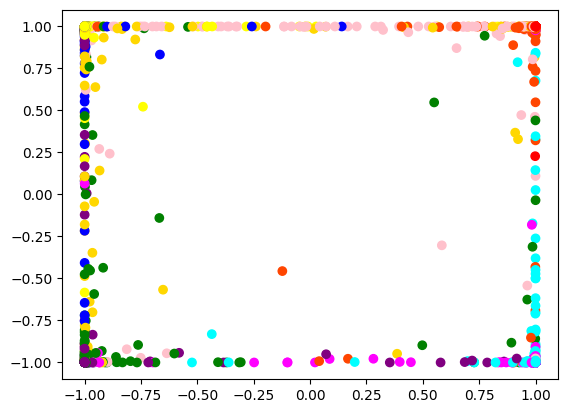

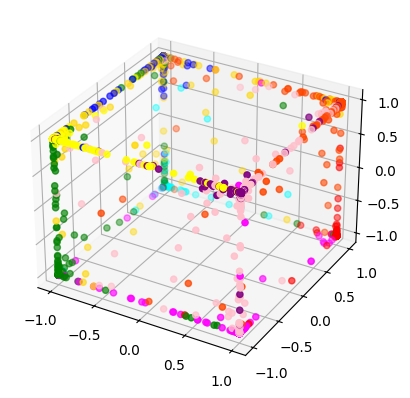

In [60]:
############### Problem b ###################
# Visualization with 2 hidden units
clf = MLP(num_hid = 2)
_ = clf.fit(train_x, train_y, valid_x, valid_y)

# Generate and visualize 2D hidden features from validation set
hid_features = clf.get_hidden(valid_x)
plot2d(hid_features, valid_y, "valid")

# Visualization with 3 hidden units
clf = MLP(num_hid = 3)
_ = clf.fit(train_x, train_y, valid_x, valid_y)

# Generate and visualize 3D hidden features from validation set
hid_features = clf.get_hidden(valid_x)
plot3d(hid_features, valid_y, "valid")

### Question 2: Compare the two figures and explain the results (any reasonable explanation is sufficient).

[Answer goes here]
The top most figure is 2D scatter plot and the bottom figure is 3D scatter plot. These figures shows the two hidden units from the validation set. In 2D figure, the data points are more squeezed along the borders at -1 and 1. The classes are not clearly separable and there is much more overlapping between the clusters. While in case of 3D figure, the classes are more separable and it is better able to capture the complex pattern in the validation set. The 3D plot better visualizes the separation of digit classes. 